In [6]:
import bs4 as bs
import urllib.request
import pandas as pd

def extract_player_data(table_rows_variable):
    """
    Extract and return the desired information from the td elements within the table rows.
    :param table_rows_variable:
    :return:
    """
    # Create the emply list to store the player data
    player_data = []
    for row in table_rows_variable: #for each row, do the following:
        # Get the text for each table data (td) element in the row
        # Some player names end with
        player_list = [td.get_text()[:-2] if td.get_text().endswith("*+") else td.get_text()[:-1] if td.get_text().endswith("+") or td.get_text().endswith("*") else td.get_text() for td in row.find_all("td")]
        # there are some empty table rows, which are the repeated
        # column headers in the table
        # we skip over those rows and and continue the for loop
        if not player_list:
            continue
            # Extracting the player links
            # Instead of a list we create a dictionary, this way we can easily
            # match the player name with their pfr url
            # For all "a" elements in the row, get the text
            # NOTE: Same " HOF" text issue as the player_list above
        links_dict = {(link.get_text()): link["href"] for link in row.find_all("a", href=True)}
        player_list.insert(0, '') #TODO figure out why this is even necessary. I have an "Rk" table header, but no data for it.
        player_list.append(links_dict.get(player_list[1], ""))
        player_list.append(links_dict.get(player_list[2], ""))
        player_data.append(player_list)
    return player_data

#data = extract_player_data(table_rows)

#df_2017 = pd.DataFrame(data, columns=column_headers)

season_dfs_list = []

errors_list = []

url_template = "https://www.pro-football-reference.com/years/{year}/fantasy.htm"
# for each year from 2000 to (and including) 2017
for year in range(2000, 2018):
    # Using try/except block to catch and inspect any urls that cause an error
    try:
        # get the season URL
        url = url_template.format(year=year)

        # get the html
        html = urllib.request.urlopen(url)

        # create the beautiful soup object
        soup = bs.BeautifulSoup(html, 'lxml')

        # get column headers
        column_headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        column_headers[1] = 'Player'
        column_headers[2] = 'Team'
        column_headers[3] = 'Position'
        column_headers[7] = 'Pass_Cmp'
        column_headers[8] = 'Pass_Att'
        column_headers[9] = 'Pass_Yds'
        column_headers[10] = 'Pass_TD'
        column_headers[11] = 'Pass_INT'
        column_headers[12] = 'Rush_Att'
        column_headers[13] = 'Rush_Yds'
        column_headers[14] = 'Rush_YpA'
        column_headers[15] = 'Rush_TD'
        column_headers[16] = 'Rec_Tgt'
        column_headers[18] = 'Rec_Yds'
        column_headers[19] = 'Rec_YpR'
        column_headers[20] = 'Rec_TD'
        column_headers[21] = 'Two_PT_Made'
        column_headers[22] = 'Two_PT_Pass'
        column_headers[23] = 'Fantasy_Pts'
        column_headers[24] = 'PPR_Pts'
        column_headers[25] = 'DraftKings_Pts'
        column_headers[26] = 'FanDuel_Pts'
        column_headers.extend(["player_nfl_link", "player_team_link"])
        

        # select the data from the tale using the '#fantasy tr' CSS selector
        table_rows = soup.select("#fantasy tr")[1:]

        # extract player data from the table rows
        player_data = extract_player_data(table_rows)

        # create the dataframe for the current fantasy season
        year_df = pd.DataFrame(player_data, columns=column_headers)

        # add the year of the season to the dataframe
        year_df.insert(0,"Season", year)

        # append the current dataframe to the list of dataframes
        season_dfs_list.append(year_df)

    except Exception as e:
        # store the url and the error it causes in a list
        error =[url, e]
        # then append it to the list of errors
        errors_list.append(error)

fantasy_df = pd.concat(season_dfs_list, ignore_index=True)

print(column_headers)
print(fantasy_df.head())



['Rk', 'Player', 'Team', 'Position', 'Age', 'G', 'GS', 'Pass_Cmp', 'Pass_Att', 'Pass_Yds', 'Pass_TD', 'Pass_INT', 'Rush_Att', 'Rush_Yds', 'Rush_YpA', 'Rush_TD', 'Rec_Tgt', 'Rec', 'Rec_Yds', 'Rec_YpR', 'Rec_TD', 'Two_PT_Made', 'Two_PT_Pass', 'Fantasy_Pts', 'PPR_Pts', 'DraftKings_Pts', 'FanDuel_Pts', 'VBD', 'PosRank', 'OvRank', 'player_nfl_link', 'player_team_link']
   Season Rk            Player Team Position Age   G  GS Pass_Cmp Pass_Att  \
0    2000       Marshall Faulk  STL       RB  27  14  14        0        0   
1    2000       Edgerrin James  IND       RB  22  16  16        0        0   
2    2000     Daunte Culpepper  MIN       QB  23  16  16      297      474   
3    2000          Jeff Garcia  SFO       QB  30  16  16      355      561   
4    2000         Eddie George  TEN       RB  27  16  16        0        0   

          ...          Two_PT_Pass Fantasy_Pts PPR_Pts DraftKings_Pts  \
0         ...                              381     460          465.9   
1         ...     

In [8]:
player_ids = fantasy_df.player_nfl_link.str.extract("/.*/.*/(.*)\.", expand=False)

fantasy_df["Player_ID"] = player_ids

pfr_url = "https://www.pro-football-reference.com/"
fantasy_df.player_nfl_link = pfr_url + fantasy_df.Player_ID

player_id_df = fantasy_df.loc[:, ["Player", "Player_ID", "player_nfl_link"]]

In [9]:
fantasy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10650 entries, 0 to 10649
Data columns (total 34 columns):
Season              10650 non-null int64
Rk                  10650 non-null object
Player              10650 non-null object
Team                10650 non-null object
Position            10650 non-null object
Age                 10650 non-null object
G                   10650 non-null object
GS                  10650 non-null object
Pass_Cmp            10650 non-null object
Pass_Att            10650 non-null object
Pass_Yds            10650 non-null object
Pass_TD             10650 non-null object
Pass_INT            10650 non-null object
Rush_Att            10650 non-null object
Rush_Yds            10650 non-null object
Rush_YpA            10650 non-null object
Rush_TD             10650 non-null object
Rec_Tgt             10650 non-null object
Rec                 10650 non-null object
Rec_Yds             10650 non-null object
Rec_YpR             10650 non-null object
Rec_TD    

In [10]:
fantasy_df = fantasy_df.apply(pd.to_numeric, errors="ignore")

In [11]:
fantasy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10650 entries, 0 to 10649
Data columns (total 34 columns):
Season              10650 non-null int64
Rk                  0 non-null float64
Player              10650 non-null object
Team                10650 non-null object
Position            10650 non-null object
Age                 10649 non-null float64
G                   10552 non-null float64
GS                  10409 non-null float64
Pass_Cmp            10649 non-null float64
Pass_Att            10649 non-null float64
Pass_Yds            10649 non-null float64
Pass_TD             10649 non-null float64
Pass_INT            10649 non-null float64
Rush_Att            10649 non-null float64
Rush_Yds            10649 non-null float64
Rush_YpA            5431 non-null float64
Rush_TD             10649 non-null float64
Rec_Tgt             10005 non-null float64
Rec                 10649 non-null float64
Rec_Yds             10649 non-null float64
Rec_YpR             7772 non-null float64

In [12]:
num_cols = fantasy_df.columns[fantasy_df.dtypes != object]

fantasy_df.loc[:, num_cols] = fantasy_df.loc[:, num_cols].fillna(0)

In [13]:
fantasy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10650 entries, 0 to 10649
Data columns (total 34 columns):
Season              10650 non-null int64
Rk                  10650 non-null float64
Player              10650 non-null object
Team                10650 non-null object
Position            10650 non-null object
Age                 10650 non-null float64
G                   10650 non-null float64
GS                  10650 non-null float64
Pass_Cmp            10650 non-null float64
Pass_Att            10650 non-null float64
Pass_Yds            10650 non-null float64
Pass_TD             10650 non-null float64
Pass_INT            10650 non-null float64
Rush_Att            10650 non-null float64
Rush_Yds            10650 non-null float64
Rush_YpA            10650 non-null float64
Rush_TD             10650 non-null float64
Rec_Tgt             10650 non-null float64
Rec                 10650 non-null float64
Rec_Yds             10650 non-null float64
Rec_YpR             10650 non-null f

In [20]:
# Import necessary packages, set some plotting styles
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams

# set the font scaling and the plot sizes
sns.set(font_scale=1.65)
rcParams["figure.figsize"] = 12, 9

/Users/coltkess/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


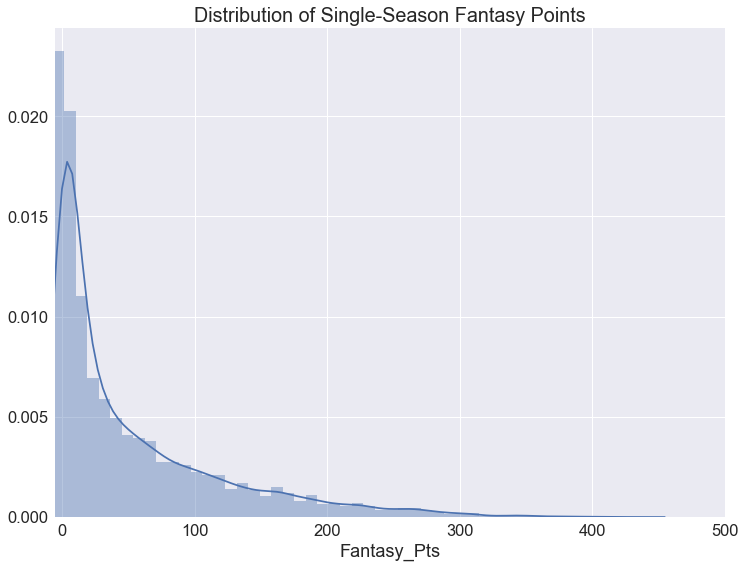

In [21]:
# Use distplot to view distribution
sns.distplot(fantasy_df.Fantasy_Pts)
plt.title("Distribution of Single-Season Fantasy Points")
plt.xlim(-5, 500)
plt.show()

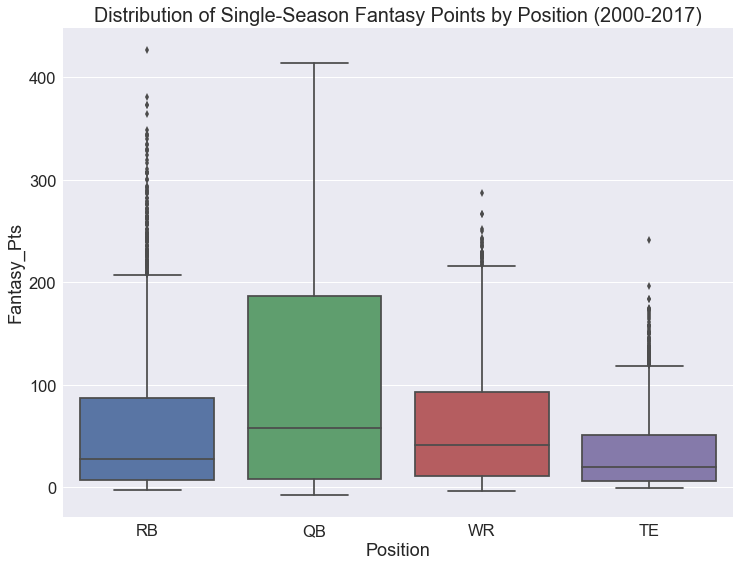

In [94]:
sns.boxplot(x="Position", y="Fantasy_Pts", data=fantasy_df.loc[(fantasy_df['Position'].isin(["QB", "RB", "WR", "TE"]))])
plt.title("Distribution of Single-Season Fantasy Points by Position (2000-2017)")
plt.show()


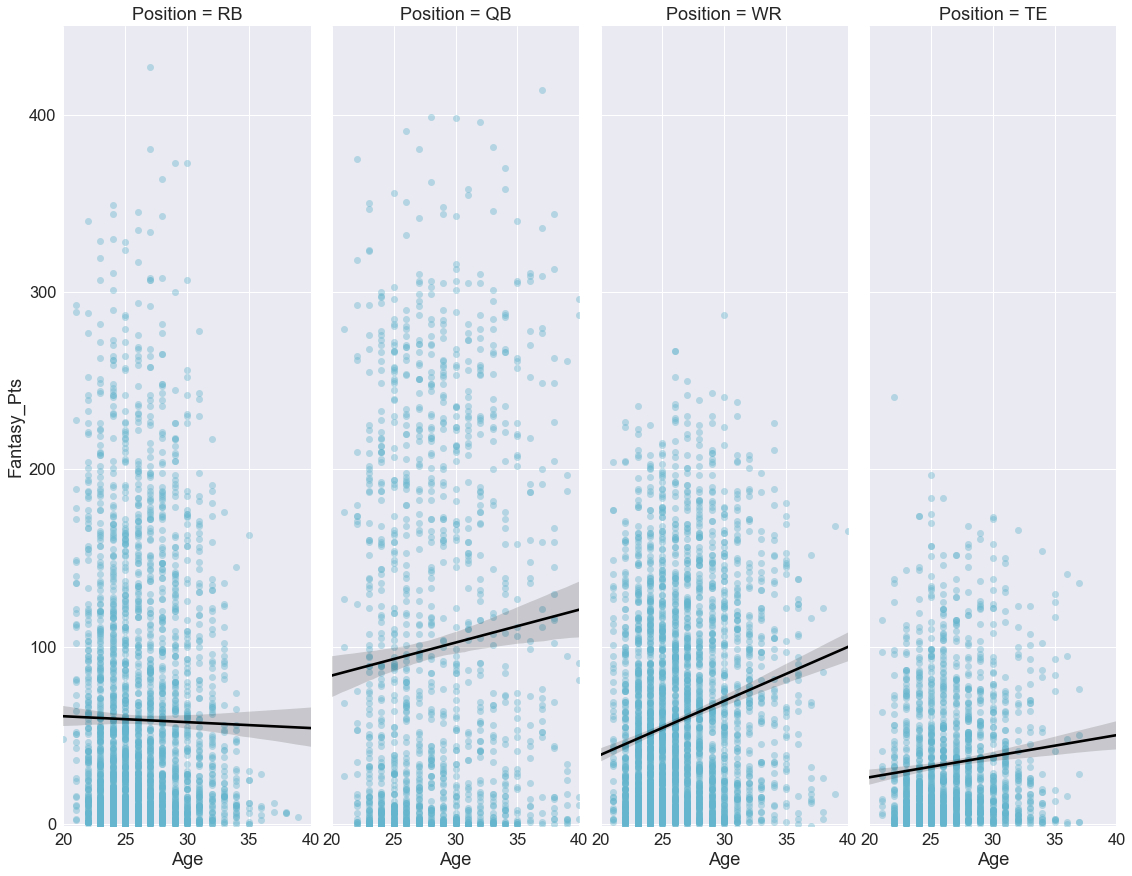

In [99]:
lm = sns.lmplot(x="Age", y="Fantasy_Pts", data=fantasy_df.loc[(fantasy_df['Position'].isin(["QB", "RB", "WR", "TE"]))], 
                fit_reg=True, col="Position", col_wrap=4, size=4, line_kws={"color": "black"}, 
                scatter_kws={"color": sns.color_palette()[5], "alpha": 0.4})
plt.subplots_adjust(top=3)

plt.xlim(20, 40)
plt.ylim(-1, 450)
plt.show()


In [100]:
teams_list = ['arizona-cardinals', 'atlanta-falcons', 'baltimore-ravens', 'buffalo-bills', 'carolina-panthers', 'chicago-bears', 'cincinnati-bengals', 'cleveland-browns', 'dallas-cowboys', 'denver-broncos', 'detroit-lions', 'green-bay-packers', 'houston-texans', 'indianapolis-colts', 'jacksonville-jaguars', 'kansas-city-chiefs', 'los-angeles-chargers', 'los-angeles-rams', 'miami-dolphins', 'minnesota-vikings', 'new-england-patriots', 'new-orleans-saints', 'new-york-giants', 'new-york-jets', 'oakland-raiders', 'philadelphia-eagles', 'pittsburgh-steelers', 'san-francisco-49ers', 'seattle-seahawks', 'tampa-bay-buccaneers', 'tennessee-titans', 'washington-redskins']



32

In [130]:
team_codes = ['arizona-cardinals', 'atlanta-falcons', 'baltimore-ravens', 'buffalo-bills', 'carolina-panthers', 'chicago-bears', 'cincinnati-bengals', 'cleveland-browns', 'dallas-cowboys', 'denver-broncos', 'detroit-lions', 'green-bay-packers', 'houston-texans', 'indianapolis-colts', 'jacksonville-jaguars', 'kansas-city-chiefs', 'los-angeles-chargers', 'los-angeles-rams', 'miami-dolphins', 'minnesota-vikings', 'new-england-patriots', 'new-orleans-saints', 'new-york-giants', 'new-york-jets', 'oakland-raiders', 'philadelphia-eagles', 'pittsburgh-steelers', 'san-francisco-49ers', 'seattle-seahawks', 'tampa-bay-buccaneers', 'tennessee-titans', 'washington-redskins']

teams_dict = {}

def get_player_cash_urls(team):
    #byte_byte = urllib.request.urlopen("https://www.spotrac.com/nfl/cleveland-browns/cap/")
    byte_byte = urllib.request.urlopen("https://www.spotrac.com/nfl/{team}/cap/".format(team=team))
    soups = bs.BeautifulSoup(byte_byte, 'lxml')

    table = soups.find("table", class_="datatable")
    tablesoup = bs.BeautifulSoup(str(table), 'lxml')

    links_dict = {(link.get_text()): link["href"] for link in tablesoup.find_all("a", href=True)}

    keys = []
    vls = []
    for k, v in links_dict.items():
        keys.append(k)
        vls.append(v)

    player_keys = []
    link_values = []
    for k in keys:
        if '(' not in k:
            player_keys.append(k)
    # ONE item in the philadelphia eagles page has a value of '-'. So this line of code removes that ONE item.
    if '-' in player_keys:
        player_keys.remove('-')

    for v in vls:
        if v != '#':
            link_values.append(v)

    splt_vls = [l.rsplit('/')[-2] for l in link_values]
    # Lots of NFL players have apostrophes in their names, but apostrophes don't work in URLs, so those have to go.
    players = [v.replace(' ', '-').replace("'","").lower() for v in player_keys]

    player_urls_dict = {}

    spotrac_url = "https://www.spotrac.com/nfl/{A}/{B}/cash-earnings/"

    for i in range(len(player_keys)):
        player_urls_dict[player_keys[i]] = spotrac_url.format(A=team, B="{}-{}".format(players[i], splt_vls[i]))

    if team.replace("-", "_").title() not in teams_dict:
        teams_dict[team.replace("-", "_").title()] = player_urls_dict

    return player_urls_dict

In [127]:
players_cash_earnings_urls_list = []
errors_list = []

for team in team_codes:
    try:
        # the team codes were already established on lines 11-16. I could have
        #  hardcoded them in ... in fact: #TODO consider hardcoding the team_codes
        players = get_player_codes(team)
        lst_of_urls = [p for p in players.values()]
        players_cash_earnings_urls_list.extend(lst_of_urls)

    except Exception as e:
        # see reference_scraper.py line 148-152
        error = [team, e]
        errors_list.append(error)

print(32*53)
print(len(players_cash_earnings_urls_list))

1696
1696


In [189]:
import re

p = re.compile("\./")
player_byte = urllib.request.urlopen("https://www.spotrac.com/nfl/chicago-bears/khalil-mack-14414/cash-earnings/")
soup = bs.BeautifulSoup(player_byte, 'lxml')
table = soup.find("table", class_="earningstable")
table_soup = bs.BeautifulSoup(str(table), 'lxml')
teams_lst = table_soup.find_all("img", src=True)
slices = [str(i).rsplit("/", 3)[-2] for i in teams_lst]
teams = [i.rsplit(".")[-2] for i in slices]

print(teams)



[<img alt="Player Cash Earnings" src="https://d1dglpr230r57l.cloudfront.net/images/thumb/oakland.png"/>, <img alt="Player Cash Earnings" src="https://d1dglpr230r57l.cloudfront.net/images/thumb/oakland.png"/>, <img alt="Player Cash Earnings" src="https://d1dglpr230r57l.cloudfront.net/images/thumb/oakland.png"/>, <img alt="Player Cash Earnings" src="https://d1dglpr230r57l.cloudfront.net/images/thumb/oakland.png"/>, <img alt="Player Cash Earnings" src="https://d1dglpr230r57l.cloudfront.net/images/thumb/bears.png"/>, <img alt="Player Cash Earnings" src="https://d1dglpr230r57l.cloudfront.net/images/thumb/bears.png"/>, <img alt="Player Cash Earnings" src="https://d1dglpr230r57l.cloudfront.net/images/thumb/bears.png"/>, <img alt="Player Cash Earnings" src="https://d1dglpr230r57l.cloudfront.net/images/thumb/bears.png"/>, <img alt="Player Cash Earnings" src="https://d1dglpr230r57l.cloudfront.net/images/thumb/bears.png"/>, <img alt="Player Cash Earnings" src="https://d1dglpr230r57l.cloudfront.ne

In [213]:
teams_dict = {}

def get_player_ids(team):
    # byte_byte = urllib.request.urlopen("https://www.spotrac.com/nfl/cleveland-browns/cap/")
    byte_byte = urllib.request.urlopen("https://www.spotrac.com/nfl/{team}/cap/".format(team=team))
    soups = bs.BeautifulSoup(byte_byte, 'lxml')

    table = soups.find("table", class_="datatable")
    tablesoup = bs.BeautifulSoup(str(table), 'lxml')

    keys = [link.get_text() for link in tablesoup.find_all("a", href=True)]
    vls = [link["href"] for link in tablesoup.find_all("a", href=True)]
    
    player_keys = []
    link_values = []
    for k in keys:
        if '(' not in k:
            player_keys.append(k)
    # ONE item in the philadelphia eagles page has a value of '-'. So this line of code removes that ONE item.
    if '-' in player_keys:
        player_keys.remove('-')
    # every other value is just "#", so those have to go.
    for v in vls:
        if v != '#':
            link_values.append(v)

    splt_vls = [l.rsplit('/')[-2] for l in link_values]

    # Lots of NFL players have apostrophes in their names, but apostrophes don't work in
    # URLs, so those have to go. This also adds the dash between first/last names.
    players = [v.replace(' ', '-').replace("'", "").lower() for v in player_keys]

    # create a blank dictionary for player urls
    player_ids_dict = {}

    #spotrac_url = "https://www.spotrac.com/nfl/{A}/{B}/cash-earnings/"
    
    spotrac_player_id = ["{}-{}".format(players[i], splt_vls[i]) for i in range(len(player_keys))]
        
    for i in range(len(player_keys)):
        player_ids_dict[player_keys[i]] = spotrac_player_id[i]

    if team not in teams_dict:
        teams_dict[team] = player_ids_dict
    
    return player_ids_dict

get_player_ids("cleveland-browns")
print(teams_dict)

{'cleveland-browns': {'Tyrod Taylor': 'tyrod-taylor-7899', 'Jarvis Landry': 'jarvis-landry-14473', 'Kevin Zeitler': 'kevin-zeitler-9837', 'Jamie Collins': 'jamie-collins-12333', 'Myles Garrett': 'myles-garrett-21742', 'J.C. Tretter': 'j.c.-tretter-12403', 'Christian Kirksey': 'christian-kirksey-14481', 'Joel Bitonio': 'joel-bitonio-14444', 'Baker Mayfield': 'baker-mayfield-25096', 'Chris Hubbard': 'chris-hubbard-12939', 'Denzel Ward': 'denzel-ward-25099', 'Travis Carrie': 'travis-carrie-14630', 'Duke Johnson': 'duke-johnson-16801', 'E.J. Gaines': 'e.j.-gaines-14599', 'Darren Fells': 'darren-fells-12008', 'Carlos Hyde': 'carlos-hyde-14467', 'Terrance Mitchell': 'terrance-mitchell-14665', 'Chris Smith': 'chris-smith-14570', 'Britton Colquitt': 'britton-colquitt-7608', 'Drew Stanton': 'drew-stanton-3331', 'Jabrill Peppers': 'jabrill-peppers-21766', 'David Njoku': 'david-njoku-21770', 'Emmanuel Ogbah': 'emmanuel-ogbah-18980', 'Damarious Randall': 'damarious-randall-16754', 'Austin Corbet':

In [214]:
sample_team_dict = {'cleveland-browns': {'Tyrod Taylor': 'tyrod-taylor-7899', 'Jarvis Landry': 'jarvis-landry-14473', 'Kevin Zeitler': 'kevin-zeitler-9837', 'Jamie Collins': 'jamie-collins-12333', 'Myles Garrett': 'myles-garrett-21742', 'J.C. Tretter': 'j.c.-tretter-12403', 'Christian Kirksey': 'christian-kirksey-14481', 'Joel Bitonio': 'joel-bitonio-14444', 'Baker Mayfield': 'baker-mayfield-25096', 'Chris Hubbard': 'chris-hubbard-12939', 'Denzel Ward': 'denzel-ward-25099', 'Travis Carrie': 'travis-carrie-14630', 'Duke Johnson': 'duke-johnson-16801', 'E.J. Gaines': 'e.j.-gaines-14599', 'Darren Fells': 'darren-fells-12008', 'Carlos Hyde': 'carlos-hyde-14467', 'Terrance Mitchell': 'terrance-mitchell-14665', 'Chris Smith': 'chris-smith-14570', 'Britton Colquitt': 'britton-colquitt-7608', 'Drew Stanton': 'drew-stanton-3331', 'Jabrill Peppers': 'jabrill-peppers-21766', 'David Njoku': 'david-njoku-21770', 'Emmanuel Ogbah': 'emmanuel-ogbah-18980', 'Damarious Randall': 'damarious-randall-16754', 'Austin Corbet': 'austin-corbet-25132', 'Nick Chubb': 'nick-chubb-25134', 'Larry Ogunjobi': 'larry-ogunjobi-21807', 'Josh Gordon': 'josh-gordon-11012', 'Greg Robinson': 'greg-robinson-14411', 'Earl Watford': 'earl-watford-12397', 'Joe Schobert': 'joe-schobert-19053', 'Derrick Kindred': 'derrick-kindred-19083', 'Chad Thomas': 'chad-thomas-25166', 'Seth Devalve': 'seth-devalve-19092', 'Carl Davis': 'carl-davis-16814', 'Charley Hughlett': 'charley-hughlett-10331', 'Antonio Callaway': 'antonio-callaway-25206', 'Orson Charles': 'orson-charles-9934', 'Briean Boddy-Calhoun': 'briean-boddy-calhoun-19638', 'Rashard Higgins': 'rashard-higgins-19126', 'Denzel Rice': 'denzel-rice-17278', 'Anthony Zettel': 'anthony-zettel-19156', 'Zane Gonzalez': 'zane-gonzalez-21966', 'James Burgess': 'james-burgess-19342', 'Trevon Coley': 'trevon-coley-19735', 'Tanner Vallejo': 'tanner-vallejo-21937', 'Genard Avery': 'genard-avery-25251', 'Damion Ratley': 'damion-ratley-25276', 'Desmond Harrison': 'desmond-harrison-25676', 'Devaroe Lawrence': 'devaroe-lawrence-22042', 'Ifeadi Odenigbo': 'ifeadi-odenigbo-21962', 'Tavierre Thomas': 'tavierre-thomas-25376', 'Derrick Willies': 'derrick-willies-25682'}}

column_headers = ['Year', 'Team', 'Salary', 'Signing Bonus', 'Roster Bonus', 'Workout Bonus', 'Restructure Bonus', 'Option Bonus', 'Incentive', 'Total Cash']

all_players_salaries_dfs_list = []

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

spotrac_url = "https://www.spotrac.com/nfl/{A}/{B}/cash-earnings/"        
#def extract_player_data(player_name, player_earnings_url):
for team_name, player_dict in sample_team_dict.items():
    for player_name, player_id in player_dict.items():
        player_byte = urllib.request.urlopen(spotrac_url.format(A=team_name, B=player_id))
        soup = bs.BeautifulSoup(player_byte, 'lxml')
        table = soup.find("table", class_="earningstable")
        table_soup = bs.BeautifulSoup(str(table), 'lxml')
    
        for row in table_soup:  # For each row, do the following:
            # 1. Get the text for each table data "td" element (basically, each cell) in the row
            player_list = [td.get_text() for td in row.find_all("td")]
        
            player_salary_history = []
            # This runs through the 
            for i in player_list:
                player_salary_history.append(i)
                if "season" in i:
                    break
            player_salary_history.pop()
    
        player_chunks = list(chunks(player_salary_history, 10))
    
        teams_lst = table_soup.find_all("img", src=True)
        slices = [str(i).rsplit("/", 3)[-2] for i in teams_lst]
        teams = [i.rsplit(".")[-2] for i in slices]
    
        for i in range(len(player_chunks)):
            player_chunks[i][1] = teams[i] 
    
        player_df = pd.DataFrame(player_chunks, columns=column_headers)
        
        player_df.insert(0, "Player_Name", player_name)
        player_df_list = player_df.values.tolist()
            
        all_players_salaries_dfs_list.append(player_df)
    
salaries_df = pd.concat(all_players_salaries_dfs_list, ignore_index=True)
           
print(salaries_df)    
    

          Player_Name  Year        Team       Salary Signing Bonus  \
0        Tyrod Taylor  2011      ravens     $375,000      $105,308   
1        Tyrod Taylor  2012      ravens     $465,000             -   
2        Tyrod Taylor  2013      ravens     $555,000             -   
3        Tyrod Taylor  2014      ravens     $645,000             -   
4        Tyrod Taylor  2015     buffalo     $750,000      $400,000   
5        Tyrod Taylor  2016     buffalo   $2,600,000    $3,400,000   
6        Tyrod Taylor  2017     buffalo   $7,500,000    $7,000,000   
7        Tyrod Taylor  2018      browns  $10,000,000             -   
8       Jarvis Landry  2014    dolphins     $420,000      $847,208   
9       Jarvis Landry  2015    dolphins     $577,951             -   
10      Jarvis Landry  2016    dolphins     $735,901             -   
11      Jarvis Landry  2017    dolphins     $893,852             -   
12      Jarvis Landry  2018      browns   $3,500,000    $7,500,000   
13      Kevin Zeitle